/tmp/ipython-input-634452052.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


Training shape: (700, 12)
Testing shape: (300, 12)

Model Performance:
Linear Regression -> RMSE: 84.02, R2: 0.8929
Random Forest -> RMSE: 11.72, R2: 0.9979
Decision Tree -> RMSE: 16.91, R2: 0.9957

Best Model Selected: RandomForestRegressor(random_state=42)


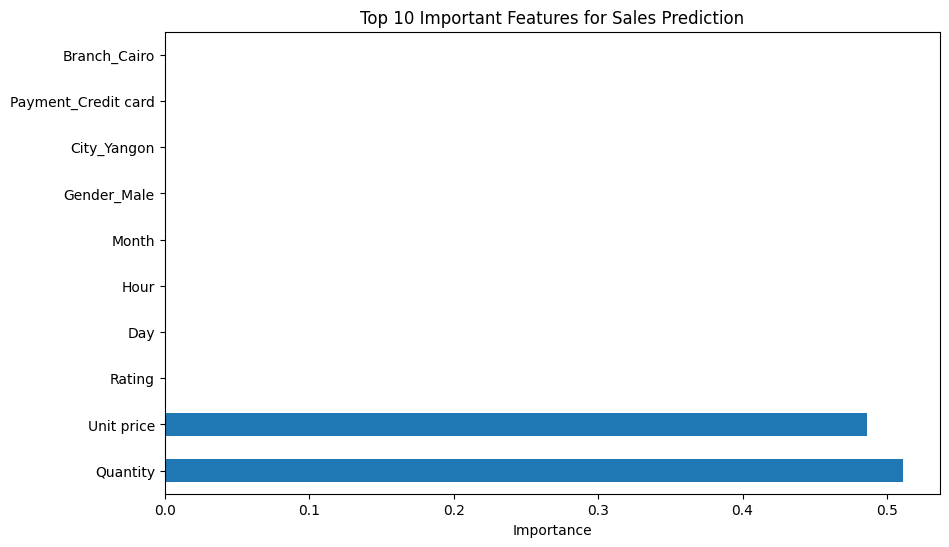

Model saved as supermarket_sales_model.pkl


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Load Data
df = pd.read_csv('SuperMarket Analysis.csv')

# 2. Preprocessing & Feature Engineering
# Convert Date/Time
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour

# Drop columns that are essentially the target variable (Data Leakage)
# We keep Unit price and Quantity as they are input parameters for a transaction
X = df.drop(['Invoice ID', 'Tax 5%', 'Sales', 'cogs', 'gross margin percentage',
             'gross income', 'Date', 'Time'], axis=1)
y = df['Sales']

# Define categorical and numerical features
categorical_cols = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment']
numerical_cols = ['Unit price', 'Quantity', 'Rating', 'Month', 'Day', 'Hour']

# Create Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# 3. Split Data (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

# 4. Model Training & Evaluation
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

results = {}
best_model = None
best_score = -np.inf

print("\nModel Performance:")
for name, model in models.items():
    # Create pipeline with preprocessor and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name} -> RMSE: {rmse:.2f}, R2: {r2:.4f}")

    if r2 > best_score:
        best_score = r2
        best_model = pipeline

print(f"\nBest Model Selected: {best_model.named_steps['model']}")

# 5. Feature Importance (for Random Forest)
if isinstance(best_model.named_steps['model'], RandomForestRegressor):
    rf_model = best_model.named_steps['model']
    ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
    feature_names = numerical_cols + list(ohe.get_feature_names_out(categorical_cols))
    importances = rf_model.feature_importances_

    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    feat_imp.head(10).plot(kind='barh')
    plt.title('Top 10 Important Features for Sales Prediction')
    plt.xlabel('Importance')
    plt.show()

# 6. Save the model for Streamlit
import joblib
joblib.dump(best_model, 'supermarket_sales_model.pkl')
print("Model saved as supermarket_sales_model.pkl")